In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The most recent date in the data set is {latest_date}.")

The most recent date in the data set is 2017-08-23.


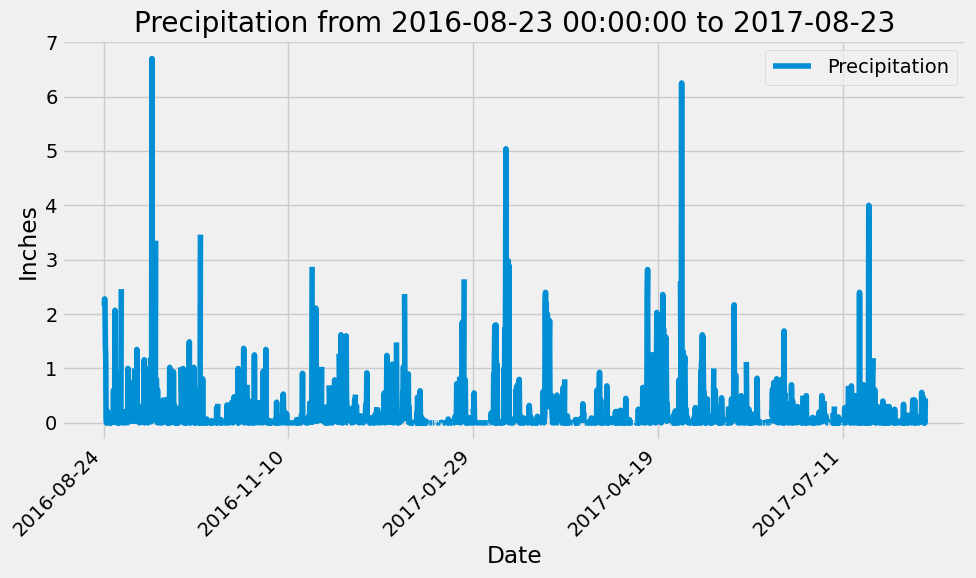

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_year_date = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])
precipitation_df.set_index("date", inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10, 6))
precipitation_df.plot(ax=ax, x_compat=True)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title(f"Precipitation from {last_year_date} to {latest_date}")
plt.legend(["Precipitation"], loc="best")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count()
print(f"There are a total of {total_stations} stations in the dataset.")

There are a total of 9 stations in the dataset.


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = (
session.query(Measurement.station, func.count(Measurement.station))
.group_by(Measurement.station)
.order_by(func.count(Measurement.station).desc())
.all()
)

print("The most active stations (in descending order) are:")
for station in active_stations:
    print(f"Station ID: {station[0]}, Count: {station[1]}")

The most active stations (in descending order) are:
Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperatures = (
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
.filter(Measurement.station == most_active_station)
.all()
)

print(f"\nFor station {most_active_station}:")
print(f"Lowest Temperature: {temperatures[0][0]} F")
print(f"Highest Temperature: {temperatures[0][1]} F")
print(f"Average Temperature: {round(temperatures[0][2], 1)} F")


For station USC00519281:
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.7 F


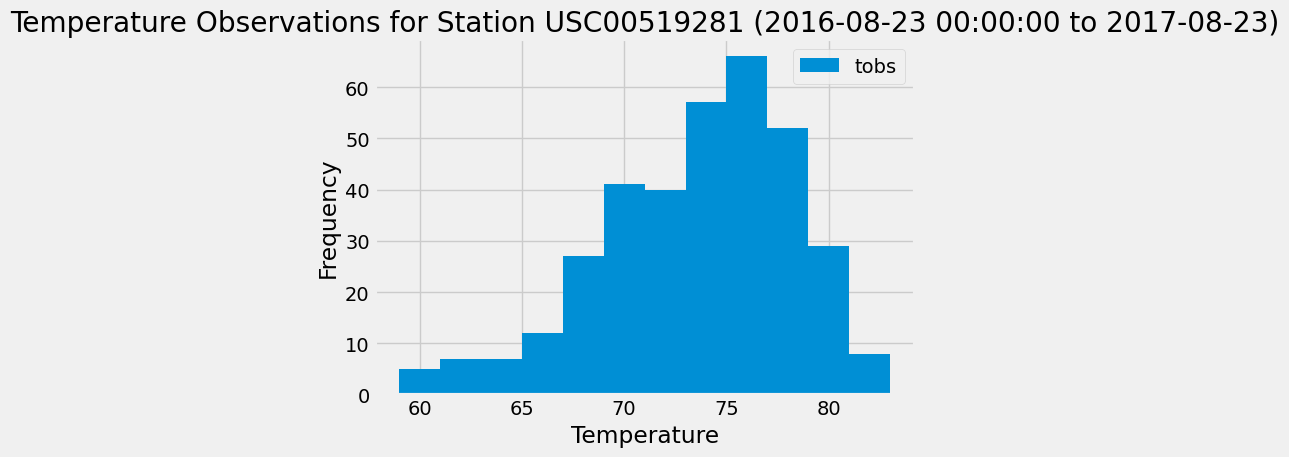

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
session.query(Measurement.tobs)
.filter(Measurement.station == most_active_station)
.filter(Measurement.date >= last_year_date)
.all()
)

temperature_df = pd.DataFrame(temperature_data, columns=["tobs"])

fig, ax = plt.subplots()
temperature_df.plot.hist(bins=12, ax=ax)

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station} ({last_year_date} to {latest_date})")
plt.tight_layout()
plt.show()

# Close session

In [21]:
# Close Session
session.close()